`Last update at 2021-03-16`

# Background

## Rounds to test
```
Round 1: 60 MAGs; 39 MS/MS-BGC links (1 correct link)
Round 2: 279 genomes/MAGs; 1 MS/MS-BGC links (0 correct link)
Round 3: 279 genomes/MAGs and 589 metagenomes; 16 MS/MS-BGC links (8 correct links)
```

## Outline

```
    3) Creating BGC fingerprints and running KNN:
    3.1) Processing NPLinker ground truth data and loading ENA_dict;
    3.2) Running BiG-SCAPE in a external server; (estimated runtime of 3h)
    3.3) Concatenating BiG-SCAPE results;
    3.4) Processing BiG-SCAPE data;
    3.5) Renaming BGCs in dataframe and dictionary;
    3.6) Creating affinity dataframe;
    3.7) Filtering affinity dataframe to create traning and testing dataframes;
    3.8) Processing KNN;
    3.9) Running cross-validation;
    3.10) Plotting fingerprints.
    
```

In [1]:
import pandas as pd
import time
import glob
import numpy as np
import csv
import subprocess
import glob
import os
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.model_selection import cross_val_score

# 3. Creating BGC fingerprints and running KNN

## 3.1. Processing NPLinker ground truth data and loading ENA_dict

In [2]:
from pyteomics import mgf, auxiliary

with mgf.MGF('inputs/matched_mibig_gnps_update.mgf') as reader:
    for spectrum in reader:
        individual_spec = []
        individual_spec.append(spectrum)
        output_file = '/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf/%s.mgf'%(spectrum['params']['spectrumid'])
#         mgf.write(spectra=individual_spec, header='', output=output_file)

In [3]:
### additional files can be dropped in the same found at output_file

!ls /Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/selected_mgf/ | wc -l

    2178


In [4]:
ena_df = pd.read_csv('./temp_files/ena_dict-round3-210315.csv',sep=',',names=['ERR_code','ERXS_code'])

ena_dict = dict(zip(ena_df['ERXS_code'],ena_df['ERR_code']))

## 3.2. Running BiG-SCAPE in a external server

```
python /home/gerwick-lab/Desktop/bigscape/BiG-SCAPE/bigscape.py \
-i /home/gerwick-lab/Desktop/bigscape/popd_antiSMASH/ \
-o /home/gerwick-lab/Desktop/bigscape/bigscape_outputs_210124/ \
-c 12 --include_singletons --pfam_dir /home/gerwick-lab/Desktop/bigscape/
```

## 3.3. Concatenating BiG-SCAPE results

In [5]:
# %%bash

# cd ./bigscape_outputs_210124/

# rm ./bigscape_all_c030.txt
# find ./network_files/2021-01-24_15-45-51_hybrids_glocal/ -type f -name *_c0.30.network | cat > ./network_files.txt
# while read line; do cat $line >> ./pre_bigscape_all_c030.txt; done < ./network_files.txt
# awk '/Clustername/&&c++>0 {next} 1' ./pre_bigscape_all_c030.txt >> ./bigscape_all_c030.txt

For stats on the annotated metagenomes, see notebook 4 - GCF metadata

## 3.4. Processing BiG-SCAPE data

In [6]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = get_bigscape_df(input_file)
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict

In [7]:
input_bigscape_net = "/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/bigscape_outputs_210124/bigscape_all_c030.txt"

bigscape_df,bigscape_dict = main_get_families(input_bigscape_net)

# to convert from distance to similarity:
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GL383688.1.region001,GL383923.1.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,c00528_NODE_52...region001,c00951_NODE_95...region001,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,c05228_NODE_52...region001,c05977_NODE_59...region001,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,c00702_NODE_70...region001,c01700_NODE_17...region001,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,c01177_NODE_11...region001,c01186_NODE_11...region001,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [8]:
len(bigscape_dict)

458

## 3.5. Renaming BGCs in dataframe and dictionary

In [9]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file and '._' not in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Volumes/TFL190831/ming_output/antismash/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

len(gbk_list),len(new_name_list)

(6777, 6777)

In [10]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    if 'BGC' in bigscape_df['Clustername_1'].loc[i]:
        new_col1.append(bigscape_df['Clustername_1'].loc[i])
    else:
        new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    if 'BGC' in bigscape_df['Clustername_2'].loc[i]:
        new_col2.append(bigscape_df['Clustername_2'].loc[i])
    else:
        new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

bigscape_df[:5]

,Clustername_1,Clustername_2,Raw_distance,Squared_similarity,Jaccard_index,DSS_index,Adjacency_index,raw_DSS_non-anchor,raw_DSS_anchor,Non-anchor_domains,Anchor_domains,Combined_group,Shared_group
0,GCA_000144525.region001,GCA_000144855.region001,0.977518,0.955542,1.000000,0.977518,1.0,0.014224,0.038998,24,3,NRPS - NRPS,NRPS
1,ERR3941118_contigs.region001,ERR3941173_contigs.region003,0.906949,0.822557,1.000000,0.906949,1.0,0.146222,0.000000,7,1,NRPS-like - NRPS-like,NRPS-like
2,ERR3941375_contigs.region009,ERR3941223_contigs.region010,0.701125,0.491577,0.666667,0.701125,0.5,0.500000,0.198312,2,1,NRPS-like - NRPS-like,NRPS-like
3,ERR3941131_contigs.region002,ERR3941249_contigs.region003,0.705753,0.498088,0.250000,0.705753,0.0,1.000000,0.117808,1,1,NRPS-like - NRPS-like,NRPS-like
4,ERR3946716_contigs.region003,ERR3946830_contigs.region007,0.972527,0.945810,0.500000,0.972527,0.4,0.000000,0.041209,2,1,NRPS-like - NRPS-like,NRPS-like


In [11]:
bigscape_dict2 = defaultdict(list)

for key in bigscape_dict:
    for value in bigscape_dict[key]:
        if 'BGC' in value:
            bigscape_dict2[key].append(value)
        else:
            bigscape_dict2[key].append(name_dict[value])
        
len(bigscape_dict2)

458

## 3.6. Creating affinity dataframe

In [12]:
def get_pre_training_df(bigscape_df,bigscape_dict,strain_list,bigscape_bgcs):
    training_df = pd.DataFrame(columns=strain_list, index=range(0,len(bigscape_bgcs)))
    index_row = 0
    row_names = []
    for gcf in bigscape_dict:
        for cluster in bigscape_dict[gcf]:
            row_names.append(cluster)
            temp_dict = {}
            self = cluster.split(".")[0]
            temp_dict[self] = [1]
            temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                                  bigscape_df.Clustername_2.str.contains(cluster)]
            for i,r in temp_df.iterrows():
                if temp_df.Clustername_1.loc[i] == cluster:
                    target = temp_df.Clustername_2.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict:
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
                else:
                    target = temp_df.Clustername_1.loc[i]
                    target = str(target).split(".")[0]
                    if target not in temp_dict.keys():
                        temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                    else:
                        temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            for key in temp_dict:
                if len(temp_dict[key]) > 1:
                    new_value = max(temp_dict[key])
                    temp_dict[key] = new_value
                else:
                    temp_dict[key] = temp_dict[key][0]
            temp_dict["label"] = gcf
            training_df.loc[index_row] = pd.Series(temp_dict)
            index_row += 1
    training_df.fillna(0,inplace=True)
    return training_df,row_names

In [13]:
bgcs_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
strain_list = []

for item in bgcs_list:
    if "BGC" not in item:
        strain_list.append(item.split(".")[0])
strain_list = list(np.unique(strain_list))
strain_list.append("label")
    
affinity_df,affinity_bgcs = get_pre_training_df(bigscape_df,bigscape_dict2,strain_list,bgcs_list)

affinity_df.shape

(2869, 632)

In [14]:
!ls -d /Volumes/TFL190831/ming_output/antismash/*/ | wc -l

     868


In [15]:
!ls -d /Volumes/TFL190831/ming_output/antismash/ER*/ | wc -l

     589


In [16]:
affinity_df[:5]

,ERR3941051_contigs,ERR3941055_contigs,ERR3941057_contigs,ERR3941059_contigs,ERR3941060_contigs,ERR3941062_contigs,ERR3941063_contigs,ERR3941065_contigs,ERR3941067_contigs,ERR3941069_contigs,...,VIKW01,VIKX01,VIKY01,VIKZ01,VILB01,VILC01,VILD01,VILE01,VILF01,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [17]:
new_affinity_names = []

for item in list(affinity_df.columns):
    if '_contigs' in item:
        new_affinity_names.append(item.split('_')[0])
    else:
        new_affinity_names.append(item)
        
affinity_df.columns = new_affinity_names

In [18]:
affinity_df[:5]

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,VIKW01,VIKX01,VIKY01,VIKZ01,VILB01,VILC01,VILD01,VILE01,VILF01,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF2


In [19]:
# affinity_df.to_csv("./outputs/affinity_df-round3-TFL210316.txt")
# pickle.dump( affinity_bgcs, open( "./outputs/affinity_bgcs-round3-TFL210316.txt", "wb" ) )

## 3.7. Filtering affinity dataframe to create traning and testing dataframes

In [20]:
### first run the notebook 2 to process ispec_mat (by Ricardo Silva)

ispec_mat = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/dorrestein_nuno/cyano_ms/selected_ref/mass-affinity_df-round3.5-TFL210225.txt",sep="\t")

ispec_mat

,ERS4341364,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERS4356313,ERS4356314,ERS4356315,ERS4356317,ERS4356319,ERS4356320,ERS4356321,ERS4356322,ERS4356323,ERS4356324
CCMSLIB00004708843,0.000000,0.121205,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.172378,...,0.126532,0.082403,0.085568,0.09111,0.1012,0.073222,0.124417,0.149952,0.080369,0.088618
CCMSLIB00004720895,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004684845,0.037464,0.000000,0.0,0.000000,0.0,0.088112,0.552143,0.0,0.574243,0.584850,...,0.000000,0.034242,0.000000,0.00000,0.0000,0.000000,0.163274,0.000000,0.000000,0.000000
CCMSLIB00004720881,0.000000,0.000000,0.0,0.393164,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004719755,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000085222,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004694483,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004712816,0.222973,0.185385,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.258483,0.000000,0.000000
CCMSLIB00005435692,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
new_cols_ispec = []

for item in ispec_mat.columns:
    if 'ERS' in item or 'ERX' in item:
        new_cols_ispec.append(ena_dict[item])
    else:
        new_cols_ispec.append(item)
        
ispec_mat.columns = new_cols_ispec

ispec_mat

,ERR3941050,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,ERR3958139,ERR3958140,ERR3958141,ERR3958143,ERR3958145,ERR3958146,ERR3958147,ERR3958148,ERR3958149,ERR3958150
CCMSLIB00004708843,0.000000,0.121205,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.172378,...,0.126532,0.082403,0.085568,0.09111,0.1012,0.073222,0.124417,0.149952,0.080369,0.088618
CCMSLIB00004720895,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004684845,0.037464,0.000000,0.0,0.000000,0.0,0.088112,0.552143,0.0,0.574243,0.584850,...,0.000000,0.034242,0.000000,0.00000,0.0000,0.000000,0.163274,0.000000,0.000000,0.000000
CCMSLIB00004720881,0.000000,0.000000,0.0,0.393164,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004719755,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000085222,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004694483,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
CCMSLIB00004712816,0.222973,0.185385,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.258483,0.000000,0.000000
CCMSLIB00005435692,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
networked_cols = []

for item in ispec_mat.columns:
    if item in affinity_df.columns:
        networked_cols.append(item)
        
len(networked_cols)

579

In [23]:
specn = os.listdir("/Volumes/TFL190831/podp_LCMS/")

filt_specn = []

for item in specn:
    if '._' not in item:
        filt_specn.append(item.split('.')[0])

filt_specn = list(np.unique(filt_specn))
        
len(filt_specn)

850

In [24]:
training_df = affinity_df[networked_cols]
label_col = affinity_df['label']
training_df = training_df[(training_df.T != 0).any()]

filt_label_col = []
for n,item in enumerate(label_col):
    if n in training_df.index:
        filt_label_col.append(item)


training_df['label'] = filt_label_col
training_df = training_df.sort_index(axis=1)

training_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,0.817521,0.0,0.0,0.0,0.0,0.0,GCF1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.744399,0.725292,0.0,0.0,0.0,0.0,0.0,GCF1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.854972,0.0,0.0,0.0,0.0,0.0,GCF1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.817521,1.000000,0.0,0.0,0.0,0.0,0.0,GCF1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF456
2865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF457
2866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF457
2867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,GCF458


In [25]:
training_df[training_df['ERR3941051'] != 0]

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345,label
324,0.820000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
340,1.000000,0.0,0.0,0.0,0.0,0.0,0.961524,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
344,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
346,0.961524,0.0,0.0,0.0,0.0,0.0,0.980000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
350,0.961524,0.0,0.0,0.0,0.0,0.0,0.980000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
351,0.820000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
359,0.947286,0.0,0.0,0.0,0.0,0.0,0.965762,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
371,0.820000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
373,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29
378,0.961524,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GCF29


In [26]:
testing_df = ispec_mat[networked_cols]
testing_df = testing_df.sort_index(axis=1) ### comment this line out for random result
testing_df = testing_df[testing_df > 0.7].replace(np.nan,0)
testing_df = testing_df[(testing_df.T != 0).any()]

testing_df

,ERR3941051,ERR3941055,ERR3941057,ERR3941059,ERR3941060,ERR3941062,ERR3941063,ERR3941065,ERR3941067,ERR3941069,...,GCA_001562525,GCA_001625105,GCA_002899455,GCA_002994615,GCA_002994635,GCA_003248315,GCA_003324555,GCA_003610995,GCA_007363395,GCA_011290345
CCMSLIB00004679300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00005436037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.908197,0.804565,0.0,0.0,0.0,0.0,0.0
CCMSLIB00005435933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000220746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.794071,0.760983,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004681475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00000222347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.705719,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CCMSLIB00004691921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [27]:
ispec_mat.shape,training_df.shape,testing_df.shape

((1754, 786), (2564, 580), (95, 579))

In [28]:
# training_df.to_csv('./outputs/training_df-round3-TFL210316.tsv',sep='\t')
# testing_df.to_csv('./outputs/testing_df-round3-TFL210316.tsv',sep='\t')

## 3.8. Processing KNN

In [29]:
X_div = training_df.drop("label", axis=1)
X_div.shape

(2564, 579)

In [30]:
y_div = training_df["label"]
y_div.shape

(2564,)

In [31]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X_div,y_div)

distances, indices = nbrs.kneighbors(testing_df)

In [32]:
y_div = y_div.reset_index(drop=True)

neighbors_array = []

for item in indices:
    candidate_list = []
    for i in range(5):
        candidate_list.append(y_div[item[i]])
    neighbors_array.append(candidate_list)

neighbors_array = np.asarray(neighbors_array)
        
neighbors_array

array([['GCF182', 'GCF160', 'GCF166', 'GCF154', 'GCF105'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF141'],
       ['GCF250', 'GCF1', 'GCF250', 'GCF242', 'GCF251'],
       ['GCF131', 'GCF10', 'GCF141', 'GCF162', 'GCF162'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF141'],
       ['GCF380', 'GCF380', 'GCF1', 'GCF367', 'GCF367'],
       ['GCF107', 'GCF108', 'GCF105', 'GCF283', 'GCF107'],
       ['GCF300', 'GCF283', 'GCF303', 'GCF131', 'GCF10'],
       ['GCF335', 'GCF29', 'GCF283', 'GCF451', 'GCF451'],
       ['GCF189', 'GCF160', 'GCF166', 'GCF182', 'GCF160'],
       ['GCF107', 'GCF108', 'GCF105', 'GCF107', 'GCF108'],
       ['GCF171', 'GCF171', 'GCF131', 'GCF10', 'GCF141'],
       ['GCF283', 'GCF405', 'GCF334', 'GCF402', 'GCF402'],
       ['GCF182', 'GCF160', 'GCF166', 'GCF154', 'GCF105'],
       ['GCF388', 'GCF308', 'GCF388', 'GCF131', 'GCF10'],
       ['GCF334', 'GCF303', 'GCF283', 'GCF383', 'GCF319'],
       ['GCF188', 'GCF188', 'GCF131', 'GCF10', 'GCF141'],
       ['

In [33]:
len(testing_df),len(neighbors_array)

(95, 95)

In [35]:
mibig_gnps_dict = {}
mibig_gnps_df = pd.read_csv('/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NPOmix/inputs/matched_mibig_gnps_update.tsv',sep='\t')
mibig_gnps_dict = dict(zip(mibig_gnps_df['# mgf_spectrum_id'],mibig_gnps_df['mibig_id']))

In [36]:
correct_count = 0
incorrect_count = 0
ccms_id_list = []

for index,ccms_id in enumerate(testing_df.index):
    if ccms_id in mibig_gnps_dict:
        for i,bgc in enumerate(affinity_bgcs):
            if mibig_gnps_dict[ccms_id] in bgc:
                print(ccms_id,affinity_df.label[i],neighbors_array[index])
                if affinity_df.label[i] in neighbors_array[index]:
                    print("Correct")
                    correct_count += 1
                    ccms_id_list.append('%s %s'%(ccms_id,mibig_gnps_dict[ccms_id]))
                else:
                    print("Incorrect")
                    incorrect_count += 1
                    ccms_id_list.append('%s %s'%(ccms_id,mibig_gnps_dict[ccms_id]))
                    
total_count = incorrect_count + correct_count

print('Precision = %s/%s = %s'%(correct_count,total_count,(correct_count/total_count)))

CCMSLIB00004679300 GCF166 ['GCF182' 'GCF160' 'GCF166' 'GCF154' 'GCF105']
Correct
CCMSLIB00004681487 GCF188 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF141']
Correct
CCMSLIB00005436037 GCF107 ['GCF250' 'GCF1' 'GCF250' 'GCF242' 'GCF251']
Incorrect
CCMSLIB00004681486 GCF188 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF141']
Correct
CCMSLIB00004692003 GCF95 ['GCF335' 'GCF29' 'GCF283' 'GCF451' 'GCF451']
Incorrect
CCMSLIB00004679299 GCF166 ['GCF182' 'GCF160' 'GCF166' 'GCF154' 'GCF105']
Correct
CCMSLIB00004681481 GCF188 ['GCF188' 'GCF188' 'GCF131' 'GCF10' 'GCF141']
Correct
CCMSLIB00004679298 GCF166 ['GCF182' 'GCF160' 'GCF154' 'GCF154' 'GCF105']
Incorrect
CCMSLIB00004681482 GCF107 ['GCF239' 'GCF241' 'GCF245' 'GCF240' 'GCF242']
Incorrect
CCMSLIB00000839195 GCF107 ['GCF189' 'GCF160' 'GCF166' 'GCF182' 'GCF160']
Incorrect
CCMSLIB00004685866 GCF160 ['GCF32' 'GCF198' 'GCF20' 'GCF32' 'GCF198']
Incorrect
CCMSLIB00000479759 GCF151 ['GCF28' 'GCF28' 'GCF131' 'GCF10' 'GCF141']
Incorrect
CCMSLIB00004693587 GCF160 [

In [37]:
ccms_id_list

['CCMSLIB00004679300 BGC0000399',
 'CCMSLIB00004681487 BGC0001088',
 'CCMSLIB00005436037 BGC0000936',
 'CCMSLIB00004681486 BGC0001088',
 'CCMSLIB00004692003 BGC0000262',
 'CCMSLIB00004679299 BGC0000398',
 'CCMSLIB00004681481 BGC0001088',
 'CCMSLIB00004679298 BGC0000399',
 'CCMSLIB00004681482 BGC0000936',
 'CCMSLIB00000839195 BGC0000936',
 'CCMSLIB00004685866 BGC0000281',
 'CCMSLIB00000479759 BGC0000028',
 'CCMSLIB00004693587 BGC0000281',
 'CCMSLIB00000578442 BGC0000958',
 'CCMSLIB00004681475 BGC0001088',
 'CCMSLIB00000579285 BGC0001088']

In [38]:
c = 0

for item in training_df.columns:
    if 'ERR' in item:
        c += 1
        
c,len(training_df.columns)-c,len(training_df.columns)

(450, 130, 580)

## 3.9. Running cross-validation

In [39]:
knn_cv = KNeighborsClassifier(n_neighbors=5)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X_div, y_div, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[0.62573099 0.62768031 0.61793372 0.62183236 0.63085938]
cv_scores mean:0.624807352582846


## 3.10. Plotting fingerprints

In [40]:
gcf_query = 'GCF188'

In [41]:
bigscape_dict2[gcf_query]

['GCA_000087965.region007', 'BGC0001088.1']

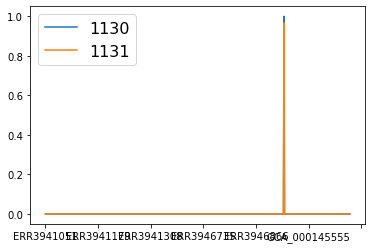

In [42]:
gcf_subset1 = training_df[training_df['label'] == gcf_query].T
gcf_subset1 = gcf_subset1.drop('label')

gcf_subset1.plot().legend(loc=2, prop={'size': 16})

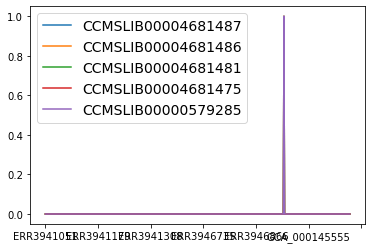

In [43]:
mf_subset1 = testing_df.loc[['CCMSLIB00004681487','CCMSLIB00004681486','CCMSLIB00004681481','CCMSLIB00004681475','CCMSLIB00000579285']].T

mf_subset1.plot().legend(loc=2, prop={'size': 14})

In [44]:
mibig_gnps_df[mibig_gnps_df['# mgf_spectrum_id'] == 'CCMSLIB00004681487']

,# mgf_spectrum_id,mgf_inchikey,mgf_smiles,mibig_id,mibig_name,mibig_inchi,mibig_smiles
2966,CCMSLIB00004681487,NaN,NaN,BGC0001088,albicidin,NaN,NaN
